#  Full ML fit

This notebook is a follow up to the Prelim_ML_fit.ipynb experiment.  It improves upon that model with variance estimation using replica method and an exploration of optimization algorithms.  Finally, a dense layer is added preceding the model to demonstrate a potential architecture for a global fit.

# Setup

In [18]:
# whenever changes are made to any imported files this will reload them automatically
%load_ext autoreload
%autoreload 2

In [19]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

print(tf.__version__)

2.3.0


In [20]:
from BHDVCStf import BHDVCS #modified bhdvcs file
bhdvcs = BHDVCS()

In [23]:
df = pd.read_csv('data.csv')

In [24]:
class DvcsData(object):
    def __init__(self, df):
        self.X = df.loc[:, ['phi_x', 'k', 'QQ', 'x_b', 't', 'F1', 'F2', 'ReH', 'ReE', 'ReHtilde', 'dvcs']]
        self.XnoCFF = df.loc[:, ['phi_x', 'k', 'QQ', 'x_b', 't', 'F1', 'F2', 'dvcs']]
        self.y = df.loc[:, 'F']
        self.Kinematics = df.loc[:, ['k', 'QQ', 'x_b', 't']]
        self.erry = df.loc[:, 'errF']
        
    def __len__(self):
        return len(self.X)
    
    def getSet(self, setNum, itemsInSet=36):
        pd.options.mode.chained_assignment = None
        subX = self.X.loc[setNum*itemsInSet:(setNum+1)*itemsInSet-1, :]
        subX['F'] = self.y.loc[setNum*itemsInSet:(setNum+1)*itemsInSet-1]
        subX['errF'] = self.erry.loc[setNum*itemsInSet:(setNum+1)*itemsInSet-1]
        pd.options.mode.chained_assignment = 'warn'
        return DvcsData(subX)
    
    def sampleY(self):
        return np.random.normal(self.y, self.erry)

In [25]:
def vecF(DvcsData, TotalUUXS):
    """
    params:
        data: this should be of type DvcsData
        TotalUUXS: this should be the function from F.C
    """
    results = np.zeros(len(data))
    for i in range(len(data)):
        results[i] = TotalUUXS(*data.X.loc[i, :])
    return results

In [26]:
class savedParams(object):
    def __init__(self, numEpochs):
        self.savedparams = pd.DataFrame({'Epoch':np.zeros(numEpochs), 'Loss':np.zeros(numEpochs),
                                         'ReH':np.zeros(numEpochs), 'ReE':np.zeros(numEpochs),
                                         'ReHtilde':np.zeros(numEpochs)})
    
    def newData(self, epoch, loss, ReH, ReE, ReHtilde):
        self.savedparams.loc[epoch, :] = {'Epoch':epoch, 'Loss':loss, 'ReH':ReH, 'ReE':ReE, 'ReHtilde':ReHtilde}

In [27]:
def pcterr(obs, exp):
    return 100*(obs-exp)/exp

In [28]:
def form(tensors): #only works for 1d tensors
    return str(np.round(np.array([x.numpy() for x in tensors]), decimals=2))

## Replica method

In [29]:
data = DvcsData(df)
set0 = data.getSet(0)
X_train = np.asarray(set0.XnoCFF).T # have to take transpose to get everything to work
y_sample = np.asarray(set0.sampleY())

In [30]:
class TotalUUXS(tf.keras.Model):
    def __init__(self):
        super(TotalUUXS, self).__init__(dtype='float64')
        self.ReH = tf.Variable(1., dtype='float64', name='ReH') # all compton form factors are set to 1.0 initially
        self.ReE = tf.Variable(1., dtype='float64', name='ReE')
        self.ReHtilde = tf.Variable(1., dtype='float64', name='ReHtilde')
        self.F = BHDVCS()
    def call(self, inputs):
        return self.F.TotalUUXS(inputs, self.ReH, self.ReE, self.ReHtilde)

In [31]:
def loss(model, inputs, targets):
    error = model(inputs) - targets
    return tf.reduce_mean(tf.square(error))

In [32]:
def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets)
    return tape.gradient(loss_value, [model.ReH, model.ReE, model.ReHtilde])

In [33]:
def training_loop(epochs, X_train, y_train, lr=5000, when2print=None):
    
    sv = savedParams(epochs)
    model = TotalUUXS()  # Should maybe be refactored
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr) # in this case we need a pretty high learning rate
    
    for i in range(epochs):
        grads = grad(model, X_train, y_train)
        optimizer.apply_gradients(zip(grads, [model.ReH, model.ReE, model.ReHtilde]), )

        epoch_loss = loss(model, X_train, y_train)
        sv.newData(i, epoch_loss.numpy(), model.ReH.numpy(), model.ReE.numpy(), model.ReHtilde.numpy())
        if when2print:
            if i % when2print == 0: # print state every __ epochs
                print("Loss at epoch {:03d}: {:.5f}".format(i, epoch_loss),
                      "Grads: " + form(grads),
                      "ReH, ReE, ReHtilde: " + form([model.ReH, model.ReE, model.ReHtilde]))
    return sv

In [42]:
print(X_train)

[[ 0.00000e+00  1.00000e+01  2.00000e+01  3.00000e+01  4.00000e+01
   5.00000e+01  6.00000e+01  7.00000e+01  8.00000e+01  9.00000e+01
   1.00000e+02  1.10000e+02  1.20000e+02  1.30000e+02  1.40000e+02
   1.50000e+02  1.60000e+02  1.70000e+02  1.80000e+02  1.90000e+02
   2.00000e+02  2.10000e+02  2.20000e+02  2.30000e+02  2.40000e+02
   2.50000e+02  2.60000e+02  2.70000e+02  2.80000e+02  2.90000e+02
   3.00000e+02  3.10000e+02  3.20000e+02  3.30000e+02  3.40000e+02
   3.50000e+02]
 [ 3.75000e+00  3.75000e+00  3.75000e+00  3.75000e+00  3.75000e+00
   3.75000e+00  3.75000e+00  3.75000e+00  3.75000e+00  3.75000e+00
   3.75000e+00  3.75000e+00  3.75000e+00  3.75000e+00  3.75000e+00
   3.75000e+00  3.75000e+00  3.75000e+00  3.75000e+00  3.75000e+00
   3.75000e+00  3.75000e+00  3.75000e+00  3.75000e+00  3.75000e+00
   3.75000e+00  3.75000e+00  3.75000e+00  3.75000e+00  3.75000e+00
   3.75000e+00  3.75000e+00  3.75000e+00  3.75000e+00  3.75000e+00
   3.75000e+00]
 [ 1.74013e+00  1.74013e+00  1

The only difference between this training loop and the one in my previous notebook is that y is being sampled each time rather than passed directly

## Run model

In [34]:
numSamples = 50
results = pd.DataFrame({
  "ReH": np.zeros(numSamples),
  "ReE": np.zeros(numSamples),
  "ReHtilde": np.zeros(numSamples)
})

In [35]:
for i in tqdm(range(numSamples)):
    setI = data.getSet(0)
    X_train = np.asarray(setI.XnoCFF).T # have to take transpose to get everything to work
    y_train = np.asarray(setI.sampleY())
    info = training_loop(1500, X_train, y_train, lr=3100)
    minloss = info.savedparams.loc[info.savedparams['Loss'].idxmin(), :]
    
    for cff in ['ReH', 'ReE', 'ReHtilde']:
        results.loc[i, cff] = minloss[cff]

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [33:53<00:00, 40.67s/it]


## Results

In [36]:
print(pd.DataFrame({'Fitted': list(results.mean()),
                'Error': list(results.std()),
                'True': list(df.loc[0, ['ReH', 'ReE', 'ReHtilde']])},
             ['ReH', 'ReE', 'ReHTilde']))

             Fitted     Error      True
ReH       12.684495  0.880815  13.05540
ReE      -51.181308  4.497768 -53.05540
ReHTilde   7.290024  0.584154   7.25302


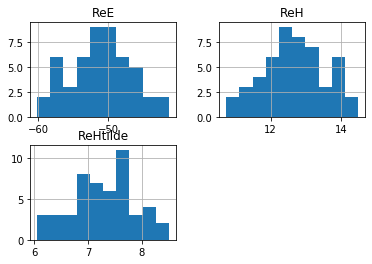

In [37]:
%matplotlib inline
results.hist()
plt.show()

In [38]:
print("95% Lower Bound:")
print(results.mean() - 2*results.std())
print("\n95% Upper Bound:")
print(results.mean() + 2*results.std())
print("\nTrue:")
print(df.loc[0, ['ReH', 'ReE', 'ReHtilde']])

95% Lower Bound:
ReH         10.922866
ReE        -60.176844
ReHtilde     6.121715
dtype: float64

95% Upper Bound:
ReH         14.446125
ReE        -42.185773
ReHtilde     8.458333
dtype: float64

True:
ReH         13.05540
ReE        -53.05540
ReHtilde     7.25302
Name: 0, dtype: float64


# Add Preceding Dense Layer

To demonstrate global fit

In [39]:
data = DvcsData(df)
set0 = data.getSet(0)

## Model

### Define functional layer

In [40]:
class TotalUUXS(tf.keras.layers.Layer):
    def __init__(self):
        super(TotalUUXS, self).__init__(dtype='float64')
        self.F = BHDVCS()
    def call(self, inputs):
        return self.F.TotalUUXS(inputs[:, :8], inputs[:, 8], inputs[:, 9], inputs[:, 10])

### Define model

In [41]:
kinematics = tf.keras.Input(shape=(4))
x = tf.keras.layers.Dense(20, activation="tanh")(kinematics)
outputs = tf.keras.layers.Dense(3)(x) #three output nodes for ReH, ReE, ReHtilde
noncffInputs = tf.keras.Input(shape=(8))
totalUUXSInputs = tf.keras.layers.concatenate([noncffInputs, outputs])
F = TotalUUXS()(totalUUXSInputs)

globalModel = tf.keras.Model(inputs=[kinematics, noncffInputs], outputs=F, name="GlobalModel")

TypeError: You are attempting to use Python control flow in a layer that was not declared to be dynamic. Pass `dynamic=True` to the class constructor.
Encountered error:
"""
in user code:

    <ipython-input-40-0196959ca834>:6 call  *
        return self.F.TotalUUXS(inputs[:, :8], inputs[:, 8], inputs[:, 9], inputs[:, 10])
    C:\Users\bijan\Tensor Fit\BHDVCStf.py:238 TotalUUXS  *
        phi, k, QQ, xb, t, F1, F2, dvcs = x # a little weird but I like the readability
    C:\Users\bijan\anaconda3\lib\site-packages\tensorflow\python\framework\ops.py:503 __iter__
        self._disallow_iteration()
    C:\Users\bijan\anaconda3\lib\site-packages\tensorflow\python\framework\ops.py:499 _disallow_iteration
        self._disallow_in_graph_mode("iterating over `tf.Tensor`")
    C:\Users\bijan\anaconda3\lib\site-packages\tensorflow\python\framework\ops.py:479 _disallow_in_graph_mode
        " this function with @tf.function.".format(task))

    OperatorNotAllowedInGraphError: iterating over `tf.Tensor` is not allowed in Graph execution. Use Eager execution or decorate this function with @tf.function.

"""

In [ ]:
tf.keras.utils.plot_model(globalModel, "cffs.png", show_shapes=True)

In [ ]:
globalModel.compile(
    optimizer = tf.keras.optimizers.Adam(1),
    loss = tf.keras.losses.MeanSquaredError(),
)

In [ ]:
globalModel.summary()

In [ ]:
def cffs_from_globalModel(model):
    subModel = tf.keras.backend.function(model.layers[0].input, model.layers[3].output)
    return subModel(np.asarray(set0.Kinematics)[None, 0])[0]

In [ ]:
numSamples = 20
results = pd.DataFrame({
  "ReH": np.zeros(numSamples),
  "ReE": np.zeros(numSamples),
  "ReHtilde": np.zeros(numSamples)
})

In [ ]:
for i in tqdm(range(numSamples)):
    setI = data.getSet(0)
    
    chkpt_path = 'networks/sample-' + str(i) + '.hdf5'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=chkpt_path,
        save_weights_only=True,
        monitor='loss',
        mode='min',
        save_best_only=True)
        
    globalModel.compile(
        optimizer = tf.keras.optimizers.Adam(1),
        loss = tf.keras.losses.MeanSquaredError(),
    )
    
    globalModel.fit([setI.Kinematics, setI.XnoCFF], setI.sampleY(),
                epochs=2000, verbose=0,
                callbacks=[model_checkpoint_callback])
    
    globalModel.load_weights(chkpt_path)

    cffs = cffs_from_globalModel(globalModel)
    
    for num, cff in enumerate(['ReH', 'ReE', 'ReHtilde']):
        results.loc[i, cff] = cffs[num]

In [ ]:
results

In [ ]:
print(pd.DataFrame({'Fitted': list(results.mean()),
                'Error': list(results.std()),
                'True': list(df.loc[0, ['ReH', 'ReE', 'ReHtilde']])},
             ['ReH', 'ReE', 'ReHTilde']))

In [ ]:
results.hist()
plt.show()

## For all layers

In [ ]:
numSamples = 20

for i in tqdm(range(max(df['#Set'])+1)):
    setI = data.getSet(i)
    
    results = pd.DataFrame({
      "ReH": np.zeros(numSamples),
      "ReE": np.zeros(numSamples),
      "ReHtilde": np.zeros(numSamples)
    })
    
    for sample in range(numSamples):

        chkpt_path = 'networks/sample-' + str(sample) + '.hdf5'
        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath=chkpt_path,
            save_weights_only=True,
            monitor='loss',
            mode='min',
            save_best_only=True)


        globalModel.fit([setI.Kinematics, setI.XnoCFF], setI.sampleY(),
                    epochs=2000, verbose=0,
                    callbacks=[model_checkpoint_callback])

        globalModel.load_weights(chkpt_path)

        cffs = cffs_from_globalModel(globalModel)

        for num, cff in enumerate(['ReH', 'ReE', 'ReHtilde']):
            results.loc[sample, cff] = cffs[num]
        
    print("\nSet " + str(i) + ":")
    print(pd.DataFrame({'Fitted': list(results.mean()),
                'Error': list(results.std()),
                'True': list(df.loc[36*i, ['ReH', 'ReE', 'ReHtilde']])},
             ['ReH', 'ReE', 'ReHTilde']))